# Import Libraries

In [257]:
%%capture
!pip install pyDOE

In [258]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Data Preparation - Helper Functions

We create several helper functions for the test data to compare against the solution produced by the PINN.

In [259]:
def create_grid(num_grid_pts=256):
    """
    Create a 2D grid of points and return them as NumPy arrays along with the
    1D arrays for each axis.

    Parameters
    ----------
    num_grid_pts : int, optional
        The number of grid points along each dimension (default is 256).

    Returns
    -------
    X : np.ndarray
        2D grid points in the x-dimension as a NumPy array.
    Y : np.ndarray
        2D grid points in the y-dimension as a NumPy array.
    x_1 : np.ndarray
        1D array of points in the x-dimension.
    x_2 : np.ndarray
        1D array of points in the y-dimension.
    """
    x_1 = np.linspace(0, np.pi, num_grid_pts)
    x_2 = np.linspace(0, np.pi, num_grid_pts)
    X, Y = np.meshgrid(x_1, x_2)

    return X, Y, x_1, x_2


def prepare_test_data(X, Y):
    """
    Prepare test data by flattening the 2D grids and stacking them column-wise.

    Parameters
    ----------
    X : np.ndarray
        2D grid points in the x-dimension as a NumPy array.
    Y : np.ndarray
        2D grid points in the y-dimension as a NumPy array.

    Returns
    -------
    X_u_test : np.ndarray
        Test data prepared by stacking the flattened x and y grids.
    lb : np.ndarray
        Lower bound for the domain (boundary conditions).
    ub : np.ndarray
        Upper bound for the domain (boundary conditions).
    """
    # Flatten the grids and stack them into a 2D array
    X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Domain bounds as NumPy arrays
    lb = np.array([0, 0], dtype=np.float32)
    ub = np.array([np.pi, np.pi], dtype=np.float32)

    return X_u_test, lb, ub


def prepare_training_data(lb, ub, num_points=1000):
    """
    Prepare training data by generating random points within the domain
    and computing the ground truth based on the analytical solution.

    Parameters
    ----------
    lb : np.ndarray
        Lower bound for the domain (boundary conditions).
    ub : np.ndarray
        Upper bound for the domain (boundary conditions).
    num_points : int, optional
        The number of random points to generate for training (default is 1000).

    Returns
    -------
    X_train : np.ndarray
        Randomly generated training points within the domain.
    u_train : np.ndarray
        Ground truth training values based on the analytical solution.
    """
    # Generate random points within the domain as training data
    X_train = lb + (ub - lb) * np.random.rand(num_points, 2)

    # Placeholder for actual training labels using a simple analytical solution
    u_train = np.sin(X_train[:, 0]) * np.sin(X_train[:, 1])

    return X_train, u_train

# Training Data

In [260]:
def prepare_training_data(N_u, N_f, lb, ub, usol, X, Y):
    """
    Prepare boundary condition data and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary condition points to select.
    N_f : int
        Number of collocation points for the physics-informed model.
    lb : np.Tensor
        Lower bound of the domain.
    ub : np.Tensor
        Upper bound of the domain.
    usol : np.Tensor
        Analytical solution of the PDE.
    X : np.Tensor
        X grid of points.
    Y : np.Tensor
        Y grid of points.

    Returns
    -------
    X_f_train : np.Tensor
        Combined collocation points and boundary points as training data.
    X_u_train : np.Tensor
        Selected boundary condition points.
    u_train : np.Tensor
        Corresponding boundary condition values.
    """

    # Extract boundary points and values from all four edges
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = usol[:, 0][:, None]

    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = usol[:, -1][:, None]

    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = usol[0, :][:, None]

    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = usol[-1, :][:, None]

    # Combine all edge points
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points from boundary
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    # Generate N_f collocation points using Latin Hypercube Sampling
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Combine collocation points with boundary points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Physics Informed Neural Network

In [261]:
class SequentialModel(nn.Module):
    """
    A custom sequential neural network model for solving boundary condition (BC) and
    partial differential equation (PDE) loss functions using PyTorch.

    Parameters
    ----------
    layers : list
        A list defining the number of nodes in each layer of the network.
    """

    def __init__(self, layers):
        """
        Initializes the SequentialModel with the specified layers, activation function,
        loss function, and weight initialization.

        Parameters
        ----------
        layers : list
            A list of integers where each element defines the number of neurons
            in the respective layer.
        """
        super().__init__()  # Call the parent class (nn.Module) initializer

        # LeakyReLU activation function
        self.activation = nn.LeakyReLU()

        # Mean squared error (MSE) loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # L1 loss function
        self.l1loss_function = nn.L1Loss(reduction='mean')

        # Initialize the network as a list of linear layers
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        # Xavier normal initialization for weights and setting biases to zero
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        """
        Forward pass through the network. Scales the input features and passes them through
        the layers of the model, applying the activation function after each layer.

        Parameters
        ----------
        x : torch.Tensor or numpy array
            Input tensor or array to be processed.

        Returns
        -------
        torch.Tensor
            Output of the model.
        """
        # Convert numpy array to tensor if needed
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        # Convert lower and upper bounds to tensors
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # Feature scaling
        x = (x - l_b) / (u_b - l_b)

        # Convert input to float
        a = x.float()

        # Pass through each linear layer with activation
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)

        # Final layer without activation
        a = self.linears[-1](a)

        return a

    def loss_BC(self, x, y):
        """
        Computes the boundary condition (BC) loss using MSE between the model's predictions
        and ground truth.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        y : torch.Tensor
            Ground truth tensor.

        Returns
        -------
        torch.Tensor
            Loss value for the boundary condition.
        """
        return self.loss_function(self.forward(x), y)

    def loss_PDE(self, x_to_train_f, k):
        """
        Computes the partial differential equation (PDE) loss using automatic differentiation
        to calculate the second-order derivatives.

        Parameters
        ----------
        x_to_train_f : torch.Tensor
            Input tensor for training PDE.
        k : int
            Wave number of the Helmholtz equation.

        Returns
        -------
        torch.Tensor
            Loss value for the PDE.
        """
        x_1_f = x_to_train_f[:, [0]]
        x_2_f = x_to_train_f[:, [1]]

        g = x_to_train_f.clone()
        g.requires_grad = True

        # Forward pass through the network
        u = self.forward(g)

        # Compute first-order derivatives
        u_x = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(device),
                            retain_graph=True, create_graph=True)[0]

        # Compute second-order derivatives
        u_xx = autograd.grad(u_x, g, torch.ones(x_to_train_f.shape).to(device),
                             create_graph=True)[0]
        u_xx_1 = u_xx[:, [0]]
        u_xx_2 = u_xx[:, [1]]

        # Define the PDE residual
        q = k**2 * torch.sin(k * x_1_f) * torch.sin(k * x_2_f)
        f = u_xx_1 + u_xx_2 + k**2 * u - q

        # PDE loss
        return self.loss_function(f, f_hat)

    def loss(self, x, y, x_to_train_f, k):
        """
        Computes the total loss by combining boundary condition (BC) loss and
        partial differential equation (PDE) loss.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor for BC.
        y : torch.Tensor
            Ground truth tensor for BC.
        x_to_train_f : torch.Tensor
            Input tensor for PDE.
        k : int
            Wave number of the Helmholtz equation.

        Returns
        -------
        torch.Tensor
            Total loss value.
        """
        loss_u = self.loss_BC(x, y)
        loss_f = self.loss_PDE(x_to_train_f, k)

        return loss_u + loss_f

    def closure(self):
        """
        Defines the closure function for the optimizer to minimize the loss. This function is
        used during the optimization process.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        adam_optimizer.zero_grad()

        # Compute total loss
        loss_val = self.loss(X_u_train, u_train, X_f_train)

        # Test the model and get error metrics
        error_vec, _ = self.test()

        print(loss, error_vec)

        # Backpropagation
        loss_val.backward()

        return loss_val

    def test(self):
        """
        Tests the model on the test data and computes the relative L2 norm of the error.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted output reshaped as a 2D array.
        """
        # Model prediction on test data
        u_pred = self.forward(X_u_test_tensor)

        # Compute relative L2 norm of the error
        error_vec = torch.linalg.norm((u - u_pred), 2) / torch.linalg.norm(u, 2)

        # Reshape the predicted output to a 2D array
        u_pred = np.reshape(u_pred.cpu().detach().numpy(), (num_grid_pts, num_grid_pts), order='F')

        return error_vec, u_pred

# *Solution Plot*

In [262]:
def solutionplot(u_pred, X_u_train, u_train):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.

    Parameters
    ----------
    u_pred : numpy.ndarray
        Predicted solution values from the model.
    X_u_train : numpy.ndarray
        Training points used for boundary conditions (not plotted but included for context).
    u_train : numpy.ndarray
        Corresponding boundary condition values (not plotted but included for context).
    """

    # Ground truth solution plot
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')  # Plot the ground truth solution 'usol' using a color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Predicted solution plot
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')  # Plot the predicted solution 'u_pred' using the same color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Absolute error plot
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')  # Plot the absolute error between ground truth and prediction
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    plt.tight_layout()  # Adjust subplots to fit into the figure area cleanly

    # Save the figure as a high-resolution image file
    plt.savefig('Helmholtz_non_stiff.png', dpi=500, bbox_inches='tight')

# LBFGS Closure

In [263]:
def LBFGS_closure():
    """
    Computes the loss and its gradients for use with the LBFGS optimizer.

    This closure function is necessary for optimizers like LBFGS which require
    multiple evaluations of the function. It performs the following:
    - Resets gradients to zero.
    - Calculates the loss using the physics-informed neural network (PINN) model.
    - Backpropagates the gradients of the loss.

    Returns
    -------
    loss : torch.Tensor
        The computed loss value.
    """
    # Zero out the gradients of the optimizer before backpropagation
    lbfgs_optimizer.zero_grad()

    # Compute the loss using the physics-informed neural network (PINN)
    loss = PINN.loss(X_u_train, u_train, X_f_train, k)

    # Perform backpropagation to compute the gradients of the loss
    loss.backward()

    # Return the loss value to the optimizer
    return loss

# Main

SequentialModel(
  (activation): LeakyReLU(negative_slope=0.01)
  (loss_function): MSELoss()
  (l1loss_function): L1Loss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1-3): 3 x Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)
Adam - Iteration 0: Loss 366.27264404296875, Error 2.3941071033477783
Adam - Iteration 200: Loss 198.42568969726562, Error 0.7338030934333801
Adam - Iteration 400: Loss 89.59732055664062, Error 0.49981167912483215
Adam - Iteration 600: Loss 29.283939361572266, Error 0.23870930075645447
Adam - Iteration 800: Loss 5.24688196182251, Error 0.1372906118631363
Adam - Iteration 1000: Loss 3.7356200218200684, Error 0.10051796585321426
Adam - Iteration 1200: Loss 2.414644241333008, Error 0.09497354924678802
Adam - Iteration 1400: Loss 1.9645318984985352, Error 0.06665118038654327
Adam - Iteration 1600: Loss 0.6470568180084229, Error 0.04689675197005272
Adam -

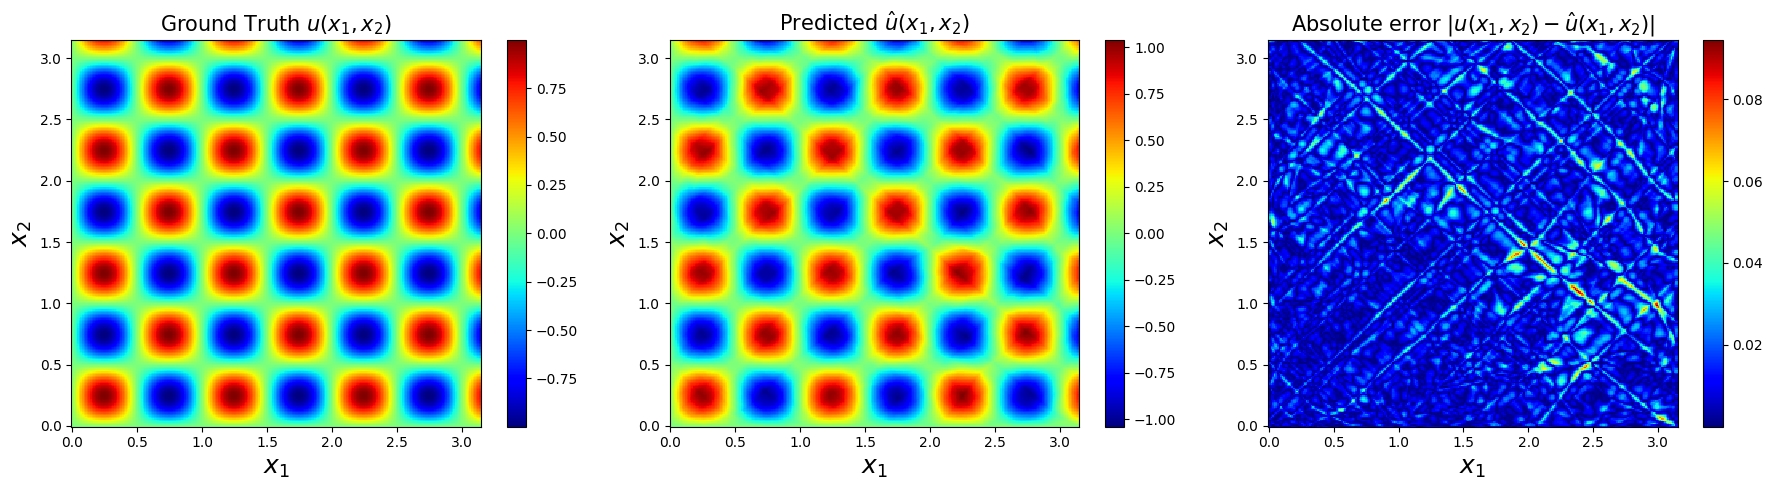

In [264]:
# Create grid and prepare test data
num_grid_pts=256
X, Y, x_1, x_2 = create_grid(num_grid_pts=num_grid_pts)  # The default is num_grid_pts=256
X_u_test, lb, ub = prepare_test_data(X, Y)

# Analytical solution of the PDE
k = 2*np.pi
usol = np.sin(k * X) * np.sin(k * Y)

# Flatten the solution in Fortran-like order and reshape it
u_true = usol.flatten()[:, None]

# Number of training points and collocation points
N_u = 500  # Total number of data points for 'u', used to train the model on boundary conditions
N_f = 10000  # Total number of collocation points for training the physics-informed part of the model

X_f_train_np_array, X_u_train_np_array, u_train_np_array = prepare_training_data(N_u, N_f, lb, ub, usol, X, Y)

# Convert the numpy arrays to PyTorch tensors and move them to the GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Neural network architecture definition

# Input layer with 2 nodes, 4 hidden layers with 200 nodes, and an output layer with 1 node
layers = np.array([2, 200, 200,200, 200, 1])

# Initialize the neural network model
PINN = SequentialModel(layers)

# Move the model to the GPU (if available)
PINN.to(device)

# Print a summary of the neural network architecture
print(PINN)

# Store the parameters of the neural network for optimization
params = list(PINN.parameters())

# Optimization Section

# Adam Optimizer
adam_optimizer = optim.Adam(PINN.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08,
                          weight_decay=1e-4, amsgrad=False)

# L-BFGS Optimizer (for fine-tuning)
lbfgs_optimizer = optim.LBFGS(PINN.parameters(), max_iter=500, tolerance_grad=1e-5, tolerance_change=1e-9,
                              history_size=100)

start_time = time.time()  # Start the timer to measure training time

# Number of iterations for Adam optimizer
adam_iter = 2000

# Adam training loop
for i in range(adam_iter):
    # Calculate the total loss (boundary condition loss + physics-informed loss)
    loss = PINN.loss(X_u_train, u_train, X_f_train, k)

    # Zero the gradient buffers of all parameters
    adam_optimizer.zero_grad()

    # Backpropagation to calculate gradients
    loss.backward()

    # Update the model parameters using the optimizer
    adam_optimizer.step()

    # Print loss and error every 200 iterations
    if i % (adam_iter // 10) == 0:
        error_vec, _ = PINN.test()  # Evaluate the model on test data
        print(f"Adam - Iteration {i}: Loss {loss.item()}, Error {error_vec.item()}")

# L-BFGS fine-tuning and optimizer
lbfgs_optimizer.step(LBFGS_closure)

# After L-BFGS optimization
error_vec, u_pred = PINN.test()
print(f'L-BFGS Test Error: {error_vec.item()}')

# Measure the elapsed training time
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

# Evaluate the model accuracy on test data
error_vec, u_pred = PINN.test()
print('Test Error: %.5f' % (error_vec))

# Plot the ground truth, predicted solution, and error
solutionplot(u_pred, X_u_train, u_train)